<a href="https://colab.research.google.com/github/Matthev00/LLM_for_forecasting/blob/master/TimeLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from typing import List

import numpy as np
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset


class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"


class SecondOfMinute(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5


class MinuteOfHour(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5


class HourOfDay(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5


class DayOfWeek(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5


class DayOfMonth(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5


class DayOfYear(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5


class MonthOfYear(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5


class WeekOfYear(TimeFeature):
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.isocalendar().week - 1) / 52.0 - 0.5


def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)


def time_features(dates, freq="h"):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])


In [4]:
from torch.utils.data import Dataset

from pathlib import Path
from typing import Tuple
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


class ETThour_Dataset(Dataset):
    def __init__(
        self,
        root_path: Path = Path("/content/drive/My Drive/TimeLLM"),
        flag: str = "train",
        size: Tuple[int, int, int] = None,
        features: str = "S",
        data_name: str = "ETTh1.csv",
        target: str = "OT",
        scale: bool = True,
        timeenc: int = 0,
        freq: str = "h",
        percent: int = 100,
    ):
        if size is None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]

        assert flag in ["train", "val", "test"]
        type_map = {"train": 0, "val": 1, "test": 2}
        self.type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq
        self.percent = percent

        self.data_path = root_path / data_name
        self.__read_data__()

        self.enc_in = self.data_x.shape[-1]
        self.tot_len = len(self.data_x) - self.seq_len - self.pred_len + 1

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(self.data_path)

        start_borders = [
            0,  # train_start
            12 * 30 * 24 - self.seq_len,  # val_start
            12 * 30 * 24 + 4 * 30 * 24 - self.seq_len,  # test_start
        ]
        end_borders = [
            12 * 30 * 24,  # train_end
            12 * 30 * 24 + 4 * 30 * 24,  # val_end
            12 * 30 * 24 + 8 * 30 * 24,  # test_end
        ]

        start_border = start_borders[self.type]
        end_border = end_borders[self.type]

        if self.type == 0:
            end_border = (end_border - self.seq_len) * self.percent // 100 + self.seq_len

        if self.features == "M" or self.features == "MS":
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == "S":
            df_data = df_raw[[self.target]]

        if self.scale:
            train_data = df_data[start_borders[0] : end_borders[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values

        df_stamp = df_raw[["date"]][start_border:end_border]
        df_stamp["date"] = pd.to_datetime(df_stamp.date)
        if self.timeenc == 0:
            df_stamp["month"] = df_stamp.date.apply(lambda row: row.month, 1)
            df_stamp["day"] = df_stamp.date.apply(lambda row: row.day, 1)
            df_stamp["weekday"] = df_stamp.date.apply(lambda row: row.weekday(), 1)
            df_stamp["hour"] = df_stamp.date.apply(lambda row: row.hour, 1)
            df_stamp = df_stamp.drop(["date"], 1).values
        elif self.timeenc == 1:
            data_stamp = time_features(
                pd.to_datetime(df_stamp["date"].values), freq=self.freq
            )
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[start_border:end_border]
        self.data_y = data[start_border:end_border]
        self.data_stamp = data_stamp

    def __len__(self):
        return (len(self.data_x) - self.seq_len - self.pred_len + 1) * self.enc_in

    def __getitem__(
        self, index: int
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        feat_id = index // self.tot_len
        s_begin = index % self.tot_len

        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len
        seq_x = self.data_x[s_begin:s_end, feat_id : feat_id + 1]
        seq_y = self.data_y[r_begin:r_end, feat_id : feat_id + 1]

        return seq_x, seq_y

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


In [5]:
from torch.utils.data import DataLoader
from typing import Tuple

data_dict = {"ETT": ETThour_Dataset}


def data_provider(args, flag: str = "train") -> Tuple[ETThour_Dataset, DataLoader]:
    Data = data_dict[args.data]
    timeenc = 0 if args.embed != "timeF" else 1
    percent = args.percent

    if flag == "test":
        shuffle_flag = False
        drop_last = False
    else:
        shuffle_flag = True
        drop_last = True
    batch_size = args.batch_size
    freq = args.freq

    data_set = Data(
        # root_path=args.root_path,
        flag=flag,
        size=(args.seq_len, args.label_len, args.pred_len),
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq,
        percent=percent,
    )

    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last,
    )
    return data_set, data_loader


# MODEL

In [6]:
import torch.nn as nn
from torch import Tensor
import torch


class ReplicationPad1d(nn.Module):
    def __init__(self, padding) -> None:
        super(ReplicationPad1d, self).__init__()
        self.padding = padding

    def forward(self, x: Tensor) -> Tensor:
        replicate_padding = x[:, :, -1].unsqueeze(-1).repeat(1, 1, self.padding[-1])
        output = torch.cat([x, replicate_padding], dim=-1)
        return output


class TokenEmbedder(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedder, self).__init__()
        self.tokenconv = nn.Conv1d(
            in_channels=c_in,
            out_channels=d_model,
            kernel_size=3,
            padding=1,
            padding_mode="circular",
            bias=False,
        )
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode="fan_in", nonlinearity="leaky_relu"
                )

    def forward(self, x: Tensor) -> Tensor:
        x = x.to(torch.float32)
        return self.tokenconv(x.permute(0, 2, 1)).transpose(1, 2)


class PatchEmbedder(nn.Module):
    def __init__(self, d_model, patch_len, stride, dropout):
        super(PatchEmbedder, self).__init__()
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch_layer = ReplicationPad1d((0, stride))
        self.value_embedding = TokenEmbedder(patch_len, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        n_vars = x.shape[1]
        x = self.padding_patch_layer(x)
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))
        x = self.value_embedding(x)
        x = self.dropout(x)
        return x, n_vars


In [7]:
class FlattenHead(nn.Module):
    def __init__(self, nf, target_window, head_dropout):
        super().__init__()
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x) -> Tensor:
        return self.dropout(self.linear(self.flatten(x)))


In [8]:
class NormalizeLayer(nn.Module):
    def __init__(
        self,
        num_features: int,
        eps=1e-5,
        affine=False,
        subtract_last=False,
        non_norm=False,
    ):
        super(NormalizeLayer, self).__init__()

        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        self.non_norm = non_norm
        if self.affine:
            self._init_params()

    def forward(self, x, mode: str) -> Tensor:
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        return x

    def _init_params(self):
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim - 1))
        if self.subtract_last:
            self.last = x[:, -1, :].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.non_norm:
            return x
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.non_norm:
            return x
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x

In [9]:
from math import sqrt


class ReprogrammingLayer(nn.Module):
    def __init__(
        self, d_model, n_heads, d_keys=None, d_llm=None, attention_dropout=0.1
    ):
        super(ReprogrammingLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)

        self.query = nn.Linear(d_model, d_keys * n_heads)
        self.key = nn.Linear(d_llm, d_keys * n_heads)
        self.value = nn.Linear(d_llm, d_keys * n_heads)
        self.out = nn.Linear(d_keys * n_heads, d_llm)
        self.n_heads = n_heads
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, target_embedding, source_embedding, value_embedding) -> Tensor:
        B, L, _ = target_embedding.shape
        S, _ = source_embedding.shape
        H = self.n_heads

        target_embedding = self.query(target_embedding).view(B, L, H, -1)
        source_embedding = self.key(source_embedding).view(S, H, -1)
        value_embedding = self.value(value_embedding).view(S, H, -1)

        out = self.reprogramming(target_embedding, source_embedding, value_embedding)

        out = out.reshape(B, L, -1)

        return self.out(out)

    def reprogramming(
        self, target_embedding, source_embedding, value_embedding
    ) -> Tensor:
        B, L, H, E = target_embedding.shape

        scale = 1.0 / sqrt(E)

        scores = torch.einsum("blhe,she->bhls", target_embedding, source_embedding)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        reprogramming_embedding = torch.einsum("bhls,she->blhe", A, value_embedding)

        return reprogramming_embedding


In [10]:
from transformers import GPT2Config, GPT2Model, GPT2Tokenizer
import torch.nn as nn
from torch import Tensor
import torch

from typing import List


class TimeLLM(nn.Module):
    def __init__(self, configs=None):
        super(TimeLLM, self).__init__()

        self.configs = configs

        self._set_llm_model()
        self._set_tokenizer()
        self._set_pad_token()
        self._freeze_llm()
        self.description = configs.content

        # layers
        self.dropout = nn.Dropout(configs.dropout)

        self.patch_embedder = PatchEmbedder(
            configs.d_model, configs.patch_len, configs.stride, configs.dropout
        )

        self.word_embeddings = self.llm_model.get_input_embeddings().weight
        vocab_size = self.word_embeddings.shape[0]
        num_tokens = 1000
        self.mapping_layer = nn.Linear(vocab_size, num_tokens)

        self.reprogramming_layer = ReprogrammingLayer(
            configs.d_model, configs.n_heads, configs.d_ff, configs.llm_dim
        )

        self.patch_nums = int(
            (configs.seq_len - configs.patch_len) / configs.stride + 2
        )
        self.head_nf = configs.d_ff * self.patch_nums

        self.output_projection = FlattenHead(
            self.head_nf, configs.pred_len, head_dropout=configs.dropout
        )

        self.normalize_layer = NormalizeLayer(configs.enc_in, affine=False)

    def forward(self, x_enc) -> Tensor:
        dec_out = self.forecast(x_enc)
        return dec_out[:, -self.configs.pred_len :, :]

    def forecast(self, x_enc) -> Tensor:
        x_enc = self.normalize_layer(x_enc, mode="norm")

        B, T, N = x_enc.size()
        x_enc = x_enc.permute(0, 2, 1).contiguous().reshape(B * N, T, 1)
        prompt = self._generate_prompt(x_enc)
        x_enc = x_enc.reshape(B, N, T).permute(0, 2, 1).contiguous()

        prompt = self.tokenizer(
            prompt, return_tensors="pt", padding=True, truncation=True, max_length=2048
        ).input_ids
        prompt_embeddings = self.llm_model.get_input_embeddings()(
            prompt.to(x_enc.device)
        )  # (batch, prompt_token, dim)

        source_embeddings = self.mapping_layer(
            self.word_embeddings.permute(1, 0)
        ).permute(1, 0)

        x_enc = x_enc.permute(0, 2, 1).contiguous()
        enc_out, n_vars = self.patch_embedder(x_enc.to(torch.bfloat16))
        enc_out = self.reprogramming_layer(
            enc_out, source_embeddings, source_embeddings
        )
        llm_enc_out = torch.cat([prompt_embeddings, enc_out], dim=1)
        dec_out = self.llm_model(inputs_embeds=llm_enc_out).last_hidden_state
        dec_out = dec_out[:, :, : self.configs.d_ff]

        dec_out = torch.reshape(
            dec_out, (-1, n_vars, dec_out.shape[-2], dec_out.shape[-1])
        )
        dec_out = dec_out.permute(0, 1, 3, 2).contiguous()

        dec_out = self.output_projection(dec_out[:, :, :, -self.patch_nums :])
        dec_out = dec_out.permute(0, 2, 1).contiguous()

        dec_out = self.normalize_layer(dec_out, "denorm")

        return dec_out

    def _calculate_lags(self, x_enc: Tensor, top_k: int = 5) -> Tensor:
        q_fft = torch.fft.rfft(x_enc.permute(0, 2, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(x_enc.permute(0, 2, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, dim=-1)
        mean_value = torch.mean(corr, dim=1)
        _, lags = torch.topk(mean_value, top_k, dim=-1)
        return lags

    def _generate_prompt(self, x_enc) -> List[str]:
        min_values = torch.min(x_enc, dim=1)[0]
        max_value = torch.max(x_enc, dim=1)[0]
        medians = torch.max(x_enc, dim=1).values
        lags = self._calculate_lags(x_enc)
        trends = x_enc.diff(dim=1).sum(dim=1)

        prompt = []
        for batch in range(x_enc.shape[0]):
            min_values_str = str(min_values[batch].tolist()[0])
            max_values_str = str(max_value[batch].tolist()[0])
            medians_str = str(medians[batch].tolist()[0])
            lags_str = str(lags[batch].tolist())
            prompt_ = (
                f"<|start_prompt|>Dataset description: {self.description}"
                f"Task description: forecast the next {str(self.configs.pred_len)} steps given the previous {str(self.configs.seq_len)} steps information; "
                "Input statistics: "
                f"min value {min_values_str}, "
                f"max value {max_values_str}, "
                f"median value {medians_str}, "
                f"the trend of input is {'upward' if trends[batch] > 0 else 'downward'}, "
                f"top 5 lags are : {lags_str}<|<end_prompt>|>"
            )
            prompt.append(prompt_)
        return prompt

    def _set_llm_model(self):
       config = GPT2Config.from_pretrained(
           "gpt2",
           output_hidden_states=True,
           cache_dir="./model/pretrained"
       )
       try:
           self.llm_model = GPT2Model.from_pretrained(
               "gpt2",
               config=config,
               cache_dir="./model/pretrained"
           )
       except Exception as e:
         print(f"Error loading GPT2 model: {e}")

    def _set_tokenizer(self):
        try:
            self.tokenizer = GPT2Tokenizer.from_pretrained(
                "openai-community/gpt2",
                trust_remote_code=True,
                local_files_only=True,
            )
        except EnvironmentError:
            print("Local tokenizer files not found. Attempting to download...")
            self.tokenizer = GPT2Tokenizer.from_pretrained(
                "openai-community/gpt2",
                trust_remote_code=True,
                local_files_only=False,
            )

    def _set_pad_token(self):
        if self.tokenizer.eos_token:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        else:
            pad_token = "[PAD]"
            self.tokenizer.add_special_tokens({"pad_token": pad_token})
            self.tokenizer.pad_token = pad_token

    def _freeze_llm(self):
        for param in self.llm_model.parameters():
            param.requires_grad = False


# Training

In [11]:
import torch
from torch.utils.tensorboard import SummaryWriter  # noqa 5501

from tqdm import tqdm
from typing import Tuple, Dict, List
from timeit import default_timer as timer


def train(
    args,
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    valid_loader: torch.utils.data.DataLoader,
    optim: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.OneCycleLR,
    criterion: torch.nn.Module,
    mae_metric: torch.nn.Module,
    epochs: int = 10,
    device: torch.device = "cuda:0",
    writer: SummaryWriter = None,
) -> Dict[str, List[float]]:
    results = {
        "train_loss": [],
        "valid_loss": [],
        "mae_loss": [],
    }
    for epoch in range(epochs):
        start = timer()
        train_loss = train_step(
            args=args,
            model=model,
            dataloader=train_loader,
            optim=optim,
            scheduler=scheduler,
            criterion=criterion,
            device=device,
        )
        adjust_lr(optim, scheduler, epoch, args)

        valid_loss, mae_loss = valid_step(
            args=args,
            model=model,
            valid_loader=valid_loader,
            criterion=criterion,
            mae_metric=mae_metric,
            device=device,
        )

        results["train_loss"].append(train_loss)
        results["valid_loss"].append(valid_loss)
        results["mae_loss"].append(mae_loss)

        print(f"Epoch {epoch+1}/{epochs}\nTime: {timer()-start}")
        print(f"Train Loss: {train_loss}\nValid Loss: {valid_loss}")

        if writer:
            writer.add_scalars(
                main_tag="Loss",
                tag_scalar_dict={"train_loss": train_loss, "test_loss": valid_loss},
                global_step=epoch,
            )

            writer.add_scalars(
                main_tag="MAE Loss",
                tag_scalar_dict={"mae_loss": mae_loss},
                global_step=epoch,
            )
    if writer:
        writer.close()
    return results


def train_step(
    args,
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optim: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.OneCycleLR,
    criterion: torch.nn.Module,
    device: torch.device = "cuda:0",
) -> float:
    model.train()
    train_loss = 0.0
    print("Training...")
    for batch_idx, (batch_x, batch_y) in tqdm(enumerate(dataloader)):
        # print(f"Batch {batch_idx + 1}/{len(dataloader)} loaded.")
        batch_x = batch_x.float().to(device)
        batch_y = batch_y[-1, :, :].float().to(device)

        outputs = model(batch_x)[0]

        f_dim = -1 if args.features == "MS" else 0
        outputs = outputs[-args.pred_len :, f_dim:]
        batch_y = batch_y[-args.pred_len :, f_dim:]

        loss = criterion(outputs, batch_y)
        train_loss += loss.item()

        optim.zero_grad()
        loss.backward()
        optim.step()
    return train_loss / len(dataloader)


def valid_step(
    args,
    model: torch.nn.Module,
    valid_loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    mae_metric: torch.nn.Module,
    device: torch.device = "cuda:0",
) -> Tuple[float, float]:
    model.eval()
    valid_loss, mae_loss = 0.0, 0.0

    with torch.no_grad():
        print("Testing...")
        for i, (batch_x, batch_y) in tqdm(enumerate(valid_loader)):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y[-1, :, :].float().to(device)

            outputs = model(batch_x)[0]

            f_dim = -1 if args.features == "MS" else 0
            outputs = outputs[-args.pred_len :, f_dim:]
            batch_y = batch_y[-args.pred_len :, f_dim:]

            loss = criterion(outputs, batch_y)
            valid_loss += loss.item()
            mae_loss += mae_metric(outputs, batch_y).item()

    return valid_loss / len(valid_loader), mae_loss / len(valid_loader)


# Utils

In [12]:
import torch
import numpy as np
import random
import argparse
from pathlib import Path
import os
from datetime import datetime


def set_seeds(seed: int = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)


def parse_argument():
    parser = argparse.ArgumentParser(description="TimeLLM")
    # data
    parser.add_argument("--data", type=str, default="ETT", help="dataset type")
    parser.add_argument(
        "--embed",
        type=str,
        default="timeF",
        help="time features encoding, options:[timeF, fixed, learned]",
    )
    parser.add_argument(
        "--freq", type=str, default="h", help="freq for time features encoding"
    )
    parser.add_argument(
        "--features",
        type=str,
        default="M",
        help="forecasting task, options:[M, S, MS]; "
        "M:multivariate predict multivariate, S: univariate predict univariate, "
        "MS:multivariate predict univariate",
    )
    parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')

    # forecasting task
    parser.add_argument("--seq_len", type=int, default=96, help="input sequence length")
    parser.add_argument("--label_len", type=int, default=48, help="start token length")
    parser.add_argument(
        "--pred_len", type=int, default=96, help="prediction sequence length"
    )

    # model define
    parser.add_argument("--enc_in", type=int, default=7, help="encoder input size")
    parser.add_argument("--d_model", type=int, default=16, help="dimension of model")
    parser.add_argument("--n_heads", type=int, default=8)
    parser.add_argument("--dropout", type=float, default=0.1)
    parser.add_argument("--patch_len", type=int, default=16)
    parser.add_argument("--stride", type=int, default=8)
    parser.add_argument("--llm_layers", type=int, default=6)
    parser.add_argument("--d_ff", type=int, default=32, help="dimension of fcn")
    parser.add_argument(
        "--llm_dim", type=int, default="768", help="LLM model dimension"
    )

    # optimization
    parser.add_argument("--train_epochs", type=int, default=10)
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument(
        "--patience", type=int, default=10, help="early stopping patience"
    )
    parser.add_argument("--learning_rate", type=float, default=0.0001)
    parser.add_argument("--pct_start", type=float, default=0.2)
    parser.add_argument("--percent", type=int, default=100)

    args = parser.parse_args()
    return args


def adjust_lr(
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler,
    epoch: int,
    args,
):
    new_lr = args.learning_rate * (0.5 ** ((epoch - 1) // 1))
    for param_group in optimizer.param_groups:
        param_group["lr"] = new_lr


def load_content(args):
    file = args.data
    with open("/content/drive/My Drive/TimeLLM/{0}.txt".format(file), "r") as f:
        content = f.read()
    return content


def save_model(model: torch.nn.Module, model_name:str):
    dir_path = Path("/content/drive/My Drive/TimeLLM/models")
    dir_path.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), dir_path / model_name)


def test_data_loading(train_loader):
    print("Testing data loading...")
    for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
        print(f"Batch {batch_idx + 1}/{len(train_loader)} loaded.")
        if batch_idx >= 5:  # Testuj tylko kilka batchy
            break
    print("Data loading test completed.")


def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None) -> SummaryWriter:

    timestamp = datetime.now().strftime("%Y-%m-%d")
    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra) # noqa 5501
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    return SummaryWriter(log_dir=log_dir)


def load_model(
    model: torch.nn.Module, model_name: str, device: torch.device = "cuda:0"
):
    dir_path = Path("/content/drive/My Drive/TimeLLM/models")
    state_dict = torch.load(f=(dir_path / model_name), map_location=device)
    model.load_state_dict(state_dict, strict=False)
    return model




# MAIN


In [13]:
class Args:
    def __init__(self, percent):
        # Dataset parameters
        self.data = "ETT"
        self.embed = "timeF"
        self.freq = "h"
        self.features = "M"
        self.target = "OT"

        # Forecasting task parameters
        self.seq_len = 96
        self.label_len = 48
        self.pred_len = 96
        self.enc_in = 7
        self.d_model = 16
        self.n_heads = 8
        self.dropout = 0.1
        self.patch_len = 16
        self.stride = 8
        self.llm_layers = 6
        self.d_ff = 32
        self.llm_dim = 768

        # Optimization parameters
        self.train_epochs = 4
        self.batch_size = 32
        self.patience = 10
        self.learning_rate = 0.0001
        self.pct_start = 0.2
        self.percent = percent

In [14]:
!pip install transformers

In [15]:
import torch
from torch import nn

import os



set_seeds()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args = Args(100)
args.content = load_content(args)
args.num_workers = os.cpu_count()
model = TimeLLM(args).float().to(device)

train_data, train_loader = data_provider(args, "train")
vali_data, vali_loader = data_provider(args, "val")
test_data, test_loader = data_provider(args, "test")
train_steps = len(train_loader)

trained_parameters = []
for p in model.parameters():
    if p.requires_grad is True:
        trained_parameters.append(p)

model = load_model(model, "time_llm_8_epochs.pth", device=device)
model.to(device)

optim = torch.optim.Adam(trained_parameters, lr=args.learning_rate)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optim,
    steps_per_epoch=train_steps,
    pct_start=args.pct_start,
    epochs=args.train_epochs,
    max_lr=args.learning_rate,
)
criterion = nn.MSELoss()
mae_metric = nn.L1Loss()

results = train(
    args=args,
    model=model,
    train_loader=train_loader,
    optim=optim,
    scheduler=scheduler,
    criterion=criterion,
    mae_metric=mae_metric,
    device=device,
    valid_loader=vali_loader,
    epochs=args.train_epochs,
    writer=create_writer("12_epochs", "time_llm_gpt2")
)

save_model(model, "time_llm_12_epochs.pth")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Local tokenizer files not found. Attempting to download...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-12-92632dcb25bb>:126: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unl

Training...


1848it [31:21,  1.02s/it]

Testing...



609it [04:56,  2.06it/s]

Epoch 1/4
Time: 2177.7077595439996
Train Loss: 1.4891038579811862
Valid Loss: 2.2140195837117465
Training...



1848it [30:59,  1.01s/it]

Testing...



609it [04:52,  2.08it/s]

Epoch 2/4
Time: 2151.695042984
Train Loss: 1.5458252796403322
Valid Loss: 2.4964373970132057
Training...



1848it [31:00,  1.01s/it]

Testing...



609it [04:51,  2.09it/s]

Epoch 3/4
Time: 2152.5824492700003
Train Loss: 1.6223760373644467
Valid Loss: 2.337153671973053
Training...



1848it [30:59,  1.01s/it]

Testing...



609it [04:51,  2.09it/s]


Epoch 4/4
Time: 2151.286515129
Train Loss: 1.5794441913177957
Valid Loss: 2.1137723152102117


In [16]:
from google.colab import files

!zip -r /content/model.zip /content/model
files.download("/content/model.zip")


  adding: content/model/ (stored 0%)
  adding: content/model/pretrained/ (stored 0%)
  adding: content/model/pretrained/models--gpt2/ (stored 0%)
  adding: content/model/pretrained/models--gpt2/refs/ (stored 0%)
  adding: content/model/pretrained/models--gpt2/refs/main (stored 0%)
  adding: content/model/pretrained/models--gpt2/blobs/ (stored 0%)
  adding: content/model/pretrained/models--gpt2/blobs/10c66461e4c109db5a2196bff4bb59be30396ed8 (deflated 50%)
  adding: content/model/pretrained/models--gpt2/blobs/248dfc3911869ec493c76e65bf2fcf7f615828b0254c12b473182f0f81d3a707 (deflated 16%)
  adding: content/model/pretrained/models--gpt2/snapshots/ (stored 0%)
  adding: content/model/pretrained/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/ (stored 0%)
  adding: content/model/pretrained/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4cfcd7e/model.safetensors (deflated 16%)
  adding: content/model/pretrained/models--gpt2/snapshots/607a30d783dfa663caf39e06633721c8d4

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluate


In [17]:
from matplotlib import pyplot as plt
from typing import Dict, List

if not results:
    results = {
        "train_loss": [
            1.4894191942488153,
            1.5807539238150985,
            1.6324307087312948,
            1.5861265380016136,
            1.590790601106546
        ],
        "valid_loss": [
            2.234617492866095,
            2.5032159727439898,
            2.3373248967722864,
            2.1020358622514554,
            2.0326186099956773
        ]
        ,
        "mae_loss": []
    }

def plot_loss_curves(results: Dict[str, List[float]]) -> None:
    """
    Plot training and validation loss curves.
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(results["train_loss"], label="Training loss", color="blue")
    plt.plot(results["valid_loss"], label="Validation loss", color="red")
    plt.title("Loss curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(results["mae_loss"], label="MAE loss", color="green")
    plt.title("MAE loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

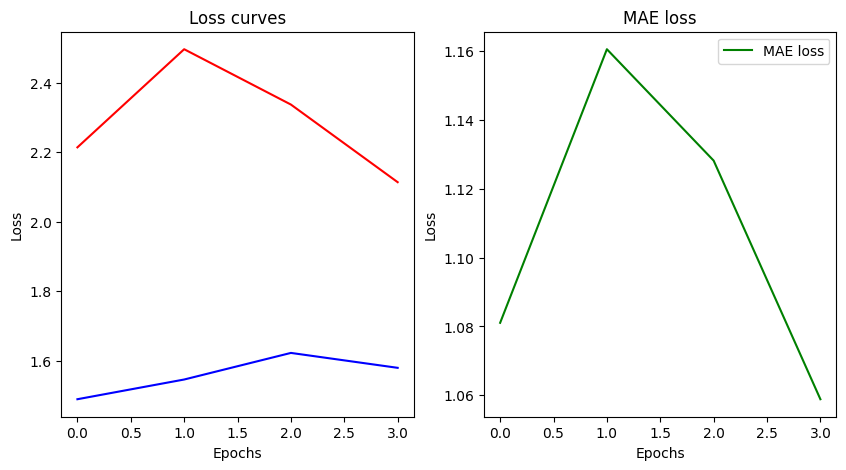

In [18]:
plot_loss_curves(results)

In [19]:
save_model(model, "time_llm_12_epochs.pth")